In [1]:
from env import host, username, password, get_db_url
import os
import pandas as pd 
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import explore 

def get_telco_data(use_cache=True):
# filename = 'telco_churn.csv'
    
    if os.path.exists('telco.csv') and use_cache:
        print('Using cached csv')
        return pd.read_csv('telco.csv')
    print('Acquiring data from SQL database')
    df = pd.read_sql('''   
                    SELECT * 
                        FROM customers
                        JOIN contract_types USING(contract_type_id)
                        JOIN internet_service_types USING(internet_service_type_id)
                        JOIN payment_types USING(payment_type_id)
                    '''
            , get_db_url('telco_churn'))
    
    df.to_csv('telco.csv', index=False)
    
    return df

# Regression: Exploration
## Exercises I - Required
***
Our Telco scenario continues:

As a customer analyst for Telco, you want to know who has spent the most money with the company over their lifetime. You have monthly charges and tenure, so you think you will be able to use those two attributes as features to estimate total charges. You need to do this within an average of $5.00 per customer.

*** 

In these exercises, you will run through the stages of exploration as you continue to work toward the above goal.

Do your work in a notebook named explore.ipynb. In addition, you should create a file named explore.py that contains the following functions for exploring your variables (features & target).



In [2]:
df = get_telco_data()

Using cached csv


In [3]:
def split_telco_data(df):
    '''
    This function performs split on telco data, stratify churn.
    Returns train, validate, and test dfs.
    '''
    # the initial 80/20 split. the test set constitutes 20% of the original df.
    train_validate, test = train_test_split(df, test_size=.2, 
                                        random_state=123)
    
    # the subsequent 70/30 split. For the remaining 80%, .7 goes to train and .3 to validate
    train, validate = train_test_split(train_validate, test_size=.3, 
                                   random_state=123)
    return train, validate, test

def prep_telco_data(df):
    # Drop duplicate columns
    df.drop(columns=['payment_type_id', 'internet_service_type_id', 'contract_type_id'], inplace=True)
       
    # Drop null values stored as whitespace    
    df['total_charges'] = df['total_charges'].str.strip()
    df = df[df.total_charges != '']
    
    df = df.set_index("customer_id")
    
    # Convert to correct datatype
    df['total_charges'] = df.total_charges.astype(float)

    # Convert binary categorical variables to numeric
    df['gender_encoded'] = df.gender.map({'Female': 1, 'Male': 0})
    df['partner_encoded'] = df.partner.map({'Yes': 1, 'No': 0})
    df['dependents_encoded'] = df.dependents.map({'Yes': 1, 'No': 0})
    df['phone_service_encoded'] = df.phone_service.map({'Yes': 1, 'No': 0})
    df['paperless_billing_encoded'] = df.paperless_billing.map({'Yes': 1, 'No': 0})
    df['churn_encoded'] = df.churn.map({'Yes': 1, 'No': 0})
    
    # Get dummies for non-binary categorical variables
    dummy_df = pd.get_dummies(df[['multiple_lines', \
                              'online_security', \
                              'online_backup', \
                              'device_protection', \
                              'tech_support', \
                              'streaming_tv', \
                              'streaming_movies', \
                              'contract_type', \
                              'internet_service_type', \
                              'payment_type']], dummy_na=False, \
                              drop_first=False)
    
    # Concatenate dummy dataframe to original 
    df = pd.concat([df, dummy_df], axis=1)
               
    
    num_cols = ['monthly_charges', 'total_charges']

    
        # Selective dummy removal since drop_first left unwanted cols and removed favored
    # kept it mostly random as far as selection of what to drop goes. Purposefully
    # excluded no internet service when optional. 
    df = df.drop(columns=['contract_type_One year', 'device_protection_No internet service',
                          'internet_service_type_DSL',
                          'multiple_lines_No phone service','online_backup_No internet service',
                          'online_security_No internet service', 'payment_type_Mailed check',
                          'streaming_movies_No internet service', 'streaming_tv_No internet service',
                          'tech_support_No internet service'
                         ]
                )
                   
    df = df.rename(columns={'internet_service_type_DSL': 'dsl',
                                   'internet_service_type_Fiber optic': 'fiber_optic',
                                   'internet_service_type_None': 'no_internet',
                                   'contract_type_Month-to-month': 'monthly',
                                   'contract_type_Two year': 'two_year_contract',
                                   'payment_type_Bank transfer (automatic)': 'auto_bank_transfer',
                                   'payment_type_Credit card (automatic)': 'auto_credit_card',
                                   'payment_type_Electronic check': 'electronic_check'
                            }
                   )
    
    
    # split the data
    train, validate, test = split_telco_data(df)
    
    return train, validate, test


1. Make sure to perform a train, validate, test split before and use only your train dataset to explore the relationships between independent variables with other independent variables or independent variables with your target variable.

In [4]:
train, validate, test = prep_telco_data(df)

In [ ]:
train.head()

In [ ]:
train.dtypes

In [15]:
x = train['tenure']
y = train['total_charges']

x2 = train.tenure
y2 = train.total_charges



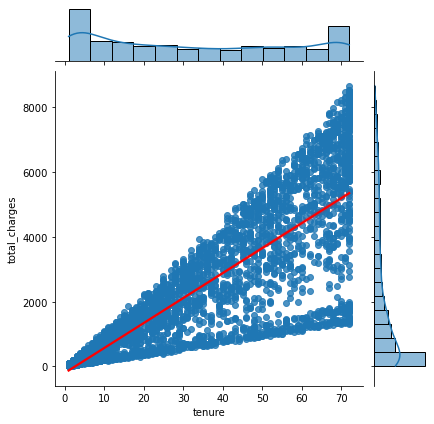

In [6]:
sns.jointplot(x="tenure", y="total_charges", data=train, kind='reg', line_kws={'color': 'red'})
plt.show()

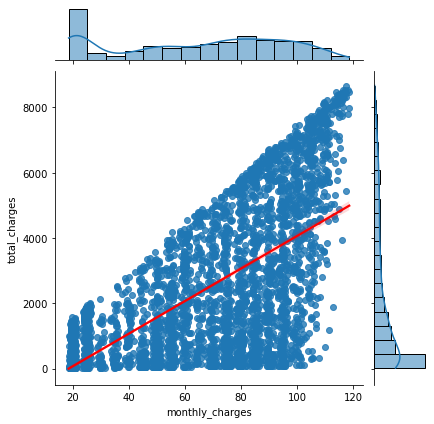

In [7]:
sns.jointplot(x="monthly_charges", y="total_charges", data=train, kind='reg', line_kws={'color': 'red'})
plt.show()

2. Write a function named plot_variable_pairs that accepts a dataframe as input and plots all of the pairwise relationships along with the regression line for each pair.

In [31]:
def plot_variable_pairs(train, cols, hue=None):
    '''
    This function takes in a df, a list of cols to plot, and default hue=None 
    and displays a pairplot with a red regression line.
    '''
    plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.7}}
    sns.pairplot(train[cols], hue=hue, kind="reg",plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.1}})
    plt.show()

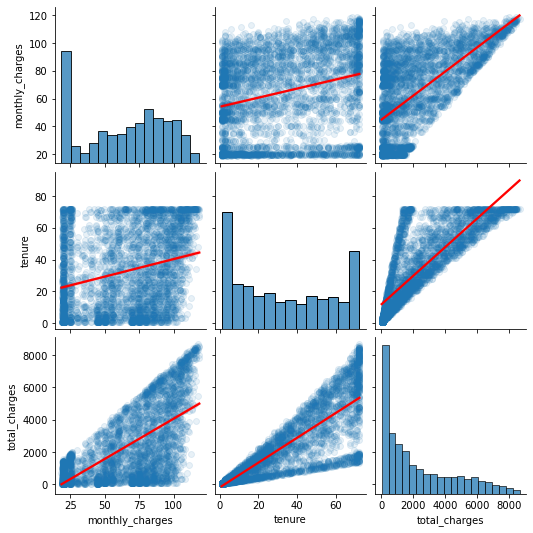

In [32]:
cols = ['monthly_charges', 'tenure', 'total_charges']

plot_variable_pairs(train, cols)
# well, it's not plotting. After ten minutes.

3. Write a function named months_to_years that accepts your telco churn dataframe and returns a dataframe with a new feature tenure_years, in complete years as a customer.

In [28]:
def months_to_years(df):
    df['tenure_years'] = (df.tenure / 12).astype(int)
    return df

In [29]:
train, validate, test = months_to_years(train), months_to_years(validate), months_to_years(test)


In [6]:
#train.dtypes


4. Write a function named plot_categorical_and_continuous_vars that accepts your dataframe and the name of the columns that hold the continuous and categorical features and outputs 3 different plots for visualizing a categorical variable and a continuous variable.

In [51]:
def plot_categorical_and_continuous_vars(categorical_var, continuous_var, df):
    """
    Accepts a string name of a categorical variable, 
    a string name from a continuous variable and their dataframe
    then it displays 4 different plots.
    """
   # fig, axes = plt.subplots(2, 2, sharex=False, figsize=(10, 12))
    
    #plt.subplot(131)
    plt.suptitle(f'{continuous_var} by {categorical_var}', fontsize=18)
    
    sns.lineplot(x=categorical_var, y=continuous_var, data=df)
    plt.xlabel(categorical_var, fontsize=12)
    plt.ylabel(continuous_var, fontsize=12)
    
   # plt.subplot(132)
    sns.catplot(x=categorical_var, y=continuous_var, data=df, kind='box', palette='deep')
    plt.xlabel(categorical_var, fontsize=12)
    plt.ylabel(continuous_var, fontsize=12)
    
   # plt.subplot(133)
    sns.catplot(x=categorical_var, y=continuous_var, data=df, kind="swarm", palette='muted')
    plt.xlabel(categorical_var, fontsize=12)
    plt.ylabel(continuous_var, fontsize=12)
    
   # plt.subplot(134)
    sns.catplot(x=categorical_var, y=continuous_var, data=df, kind="bar", palette='dark')
    plt.xlabel(categorical_var, fontsize=12)
    plt.ylabel(continuous_var, fontsize=12)


In [50]:
sns.color_palette?

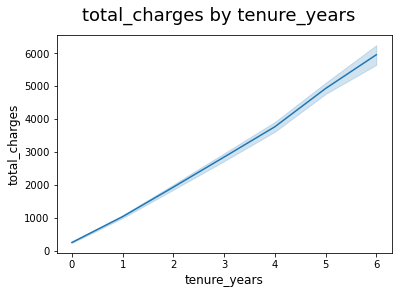

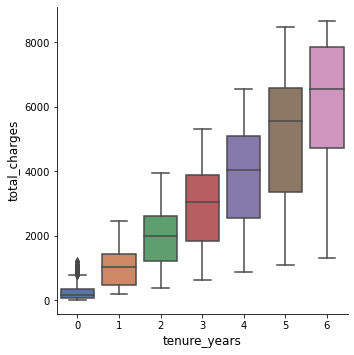

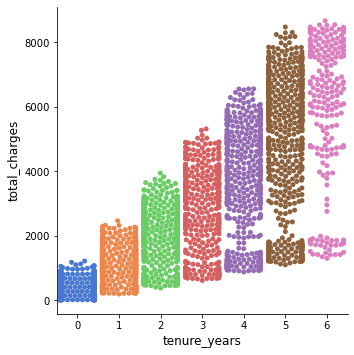

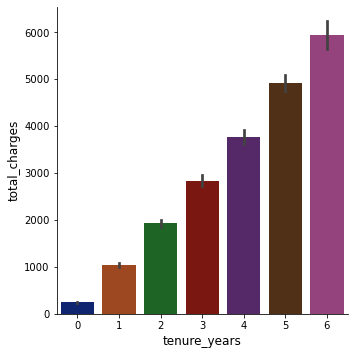

In [52]:
plot_categorical_and_continuous_vars('tenure_years', 'total_charges', train)

5. Save the functions you have written to create visualizations in your explore.py file. Rewrite your notebook code so that you are using the functions imported from this file.

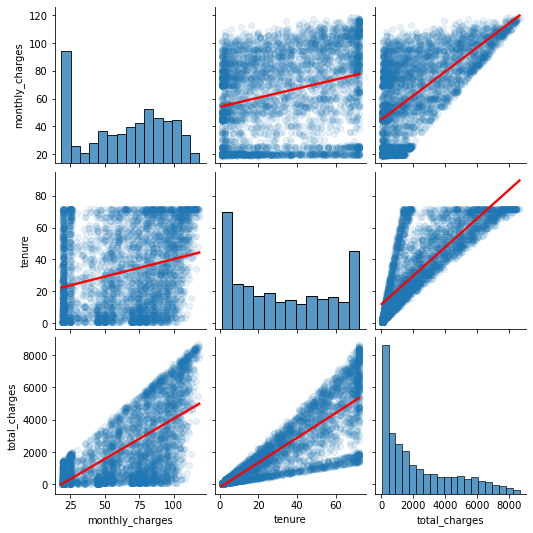

In [5]:
cols = ['monthly_charges', 'tenure', 'total_charges']

explore.plot_variable_pairs(train, cols)

In [7]:
train, validate, test = explore.months_to_years(train, validate, test)

In [10]:
#train.dtypes
#validate.dtypes
# tenure_years appears in both

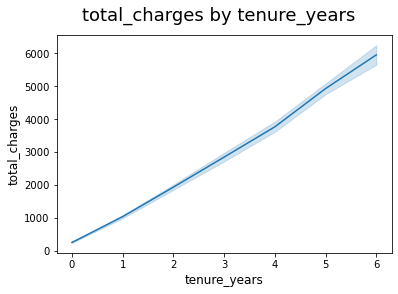

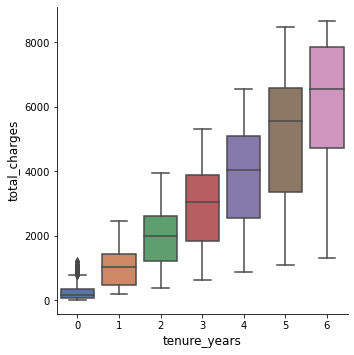

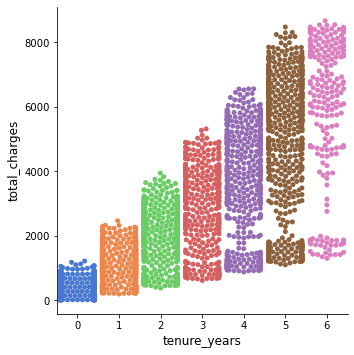

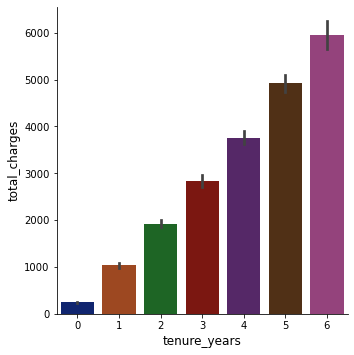

In [11]:
explore.plot_categorical_and_continuous_vars('tenure_years', 'total_charges', train)

6. Explore your dataset with any other visualizations you think will be helpful.

In [12]:
from pandas_profiling import ProfileReport
report = ProfileReport(train)

In [13]:
report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

7. Use the functions you have developed in this exercise with the mall_customers dataset in the Codeup database server. You will need to write a sql query to acquire your data. Make spending_score your target variable.

In [15]:
def acquire_mall_customers_data():
    sql = '''SELECT * FROM customers'''
    url = get_db_url('mall_customers')
    df = pd.read_sql(sql, url)
    return df

df = acquire_mall_customers_data()

In [16]:
df

customer_id  gender  age  annual_income  spending_score
0              1    Male   19             15              39
1              2    Male   21             15              81
2              3  Female   20             16               6
3              4  Female   23             16              77
4              5  Female   31             17              40
..           ...     ...  ...            ...             ...
195          196  Female   35            120              79
196          197  Female   45            126              28
197          198    Male   32            126              74
198          199    Male   32            137              18
199          200    Male   30            137              83

[200 rows x 5 columns]

In [20]:
def train_test_validate_split(df, test_size=.2, validate_size=.3, random_state=123):
    '''
    '''
    train, test = train_test_split(df, test_size=.2, random_state=123)
    train, validate = train_test_split(train, test_size=.3, random_state=123)
    
    print(f'train\t = {train.shape}')
    print(f'validate = {validate.shape}')
    print(f'test\t = {test.shape}')
    
    return train, validate, test

train, test, validate = train_test_validate_split(df)

train	 = (112, 5)
validate = (48, 5)
test	 = (40, 5)


In [22]:
train.head()

customer_id  gender  age  annual_income  spending_score
123          124    Male   39             69              91
76            77  Female   45             54              53
171          172    Male   28             87              75
10            11    Male   67             19              14
35            36  Female   21             33              81

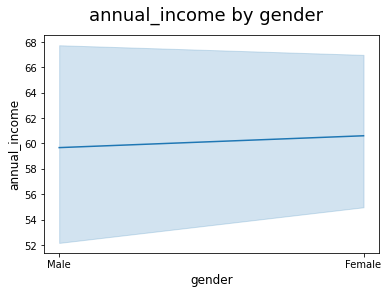

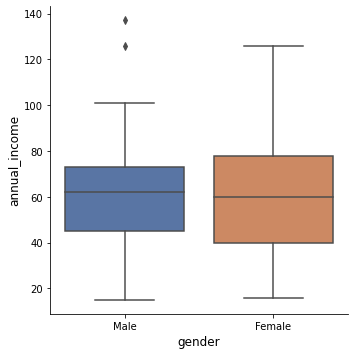

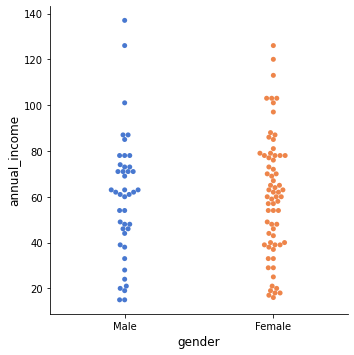

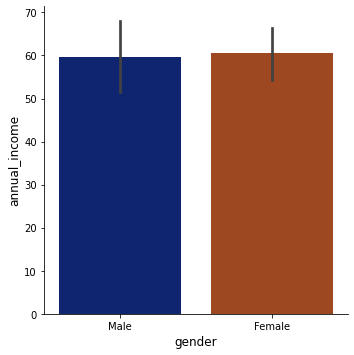

In [25]:
explore.plot_categorical_and_continuous_vars('gender', 'annual_income', train)

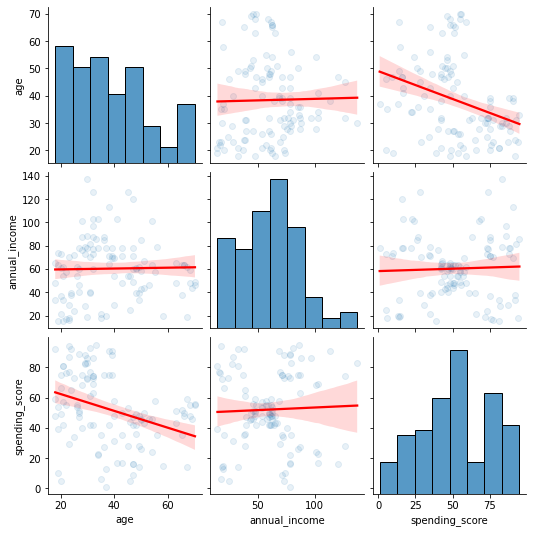

In [23]:
cols = ['age', 'annual_income', 'spending_score']

explore.plot_variable_pairs(train, cols)